In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from pydub import AudioSegment
import numpy as np

pd.set_option("max_colwidth", 40)

from fuzzywuzzy import fuzz
def get_subset(gold, model_output):
    results = list()
    gold = gold.split(" ")
    model_output = model_output.split(" ")
    M = len(gold)
    for start in range(M):
        for end in range(M):
            try:
                subset = gold[start:end]
            except IndexError:
                continue
            ratio = fuzz.ratio(" ".join(model_output), " ".join(subset))
            results.append((ratio, start, end, " ".join(subset)))
    maximum_ratio = max(results, key=lambda tup: tup[0])
    for result in results:
        if result[0] == maximum_ratio[0]:
            return result[-1]
    # return results[-1]
    raise ValueError(f"No solutions found for {gold=}, {model_output=}")

df = pd.read_csv("13_results.csv")
df["words"] = df.words.apply(literal_eval)
df["words_start_times"] = df.words_start_times.apply(literal_eval)
df["words_end_times"] = df.words_end_times.apply(literal_eval)
to_delete = np.array([len(i) == 0 for i in df.words])
print("No transcripts found for :", df.loc[to_delete, "path"])

df = df.loc[~to_delete, :]
df.reset_index(drop=True, inplace=True)



df["duration"] = -0.5
for i, row in df.iterrows():
    audio = AudioSegment.from_file(row["path"])
    df.iloc[i, -1] = audio.duration_seconds

df["sentence"] = ""
for i, row in df.iterrows():
    gold = row["sentence_uncut"]
    model_output = " ".join(row["words"])
    df.iloc[i, -1] = get_subset(gold, model_output)

df.head()

No transcripts found for : 4608    /home/peterr/macocu/task6_speech/dat...
6110    /home/peterr/macocu/task6_speech/dat...
Name: path, dtype: object


,path,sentence_uncut,original_file,words,words_start_times,words_end_times,duration,sentence
0,/home/peterr/macocu/task6_speech/dat...,dakle uvaženi kolega ja sam pozorno ...,/home/peterr/macocu/task6_speech/dat...,"[dakle, uvaženi, kolega, ja, sam, po...","[0.561111111111111, 1.60317460317460...","[0.8416666666666666, 2.0440476190476...",5.0500,dakle uvaženi kolega ja sam pozorno ...
1,/home/peterr/macocu/task6_speech/dat...,dakle uvaženi kolega ja sam pozorno ...,/home/peterr/macocu/task6_speech/dat...,"[laganje, ispomenuli, ste, riječ, ou...","[0.2805555555555555, 0.8216269841269...","[0.5410714285714285, 1.4628968253968...",5.0500,izlaganje i spomenuli ste riječ outs...
2,/home/peterr/macocu/task6_speech/dat...,i što uopće danas znači živjeti na j...,/home/peterr/macocu/task6_speech/dat...,"[i, stoopće, danas, znači, živjeti, ...","[0.06018, 0.14042, 0.441319999999999...","[0.06018, 0.38114, 0.58174, 0.862579...",5.0150,i što uopće danas znači živjeti na j...
3,/home/peterr/macocu/task6_speech/dat...,i što uopće danas znači živjeti na j...,/home/peterr/macocu/task6_speech/dat...,"[uim, dok, postla, setiče, neonego, ...","[0.10009842519685039, 0.480472440944...","[0.1801771653543307, 0.5805708661417...",5.0850,do posla stići nego sredstvima prije...
4,/home/peterr/macocu/task6_speech/dat...,građani će to znat cijeniti i volio ...,/home/peterr/macocu/task6_speech/dat...,"[gradani, će, to, znat, sijeniti, i,...","[0.12022709163346612, 0.520984063745...","[0.4207948207171314, 0.5610597609561...",5.0295,građani će to znat cijeniti i volio ...


In [47]:
final_columns = [
              'sentence',
              'sentence_uncut',
              'duration',
              'path',
              'original_file',
              'words',
              'words_start_times',
              'words_end_times',
              ]

df = df[final_columns]

In [50]:
df.to_csv("14_transcripts_ready.csv", index=False)

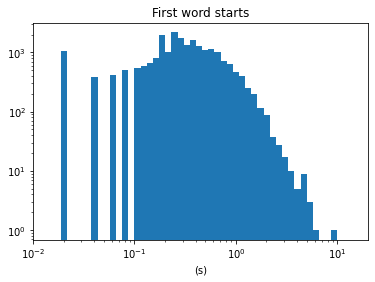

In [52]:
beginning_times = [i[0] for j, i in enumerate(df.words_start_times)]

plt.hist(beginning_times, bins=np.logspace(-5, 1, 100))
plt.semilogy()
plt.semilogx()
plt.title("First word starts")
plt.xlabel("(s)")
plt.xlim((0.01, None))
plt.savefig("images/first_word_start_position.png")
plt.show()

In [ ]:
ind = [len(i)==0 for i in df.words_start_times]
df.words_start_times[ind]

4608    []
6110    []
Name: words_start_times, dtype: object

In [21]:
df.iloc[[4608,6110], :]

,path,sentence_uncut,original_file,words,words_start_times,words_end_times,duration
4608,/home/peterr/macocu/task6_speech/data/00009994...,čestitam pravobraniteljici za osobe s invalidi...,/home/peterr/macocu/task6_speech/data/00009994...,[],[],[],7.608
6110,/home/peterr/macocu/task6_speech/data/00015098...,onda definirati zapravo jasno onda pojam samog...,/home/peterr/macocu/task6_speech/data/00015098...,[],[],[],7.000


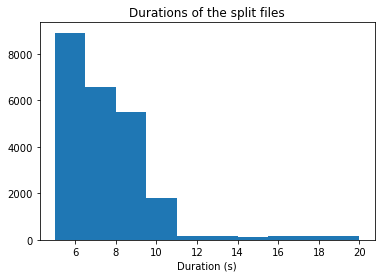

In [24]:
plt.hist(df.duration)
plt.xlabel("Duration (s)")
plt.title("Durations of the split files")
plt.savefig("images/durations_after_splitting.png")
plt.show()

In [41]:
get_subset("Hello, dragi kolegi", "dragi kolegi")

(59, 1, 2, 'dragi')